In [1]:
library(janitor)
library(arrow)
library(dplyr)
library(tibble)
library(data.table)
library(readr)



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
#Preparation dataset with molecular clock model sites only!
#Here I remove the rest of sites, calculate the sum of extracted sites and save new datasets into new folder

data_folder <- "/tank/projects/vpalagina_hobotnica/hobotnica/data_with_HC_imputed"
datasets_PhenoAge <- "/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/new_clock_dataset"

files <- list.files(data_folder)
sites <- read.table("/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/common_sites_threshold.txt", header = FALSE, sep = "\n")

output <- list()

for (i in 1:length(files)) {

  file_path <- file.path(data_folder, files[i])

  data <- read_parquet(file_path)

    if (colnames(data)[1] != "index") {
    colnames(data)[1] <- "index"
    warning(paste("First column renamed to 'index' in file:", files[i]))
  }

  sum_of_sites <- sum(data$index %in% sites$V1)
  
  # Check if there are matches between data$index and sites$V1
  matching_indices <- data$index %in% sites$V1
  if (sum(matching_indices) == 0) {
    warning(paste("No matches found in file:", files[i]))
    break
  }
  cpgs <- as.data.frame(data[matching_indices,])
  row.names(cpgs) <- cpgs$index
  cpgs <- t(cpgs)[-1, ]
  cpgs <- as.data.frame(cpgs)

  #extract datasets infromation from meta data
  meta <- read.table("computage_bench_meta.tsv", sep = "\t", header = TRUE)
  meta <- meta[,c("SampleID", "Condition", "Age", "Gender")]
  meta <- meta[meta$SampleID %in% rownames(cpgs),]
  meta <- meta %>% distinct(SampleID, .keep_all = TRUE)
  rownames(meta) <- meta$SampleID
  meta <- meta[, -c(1)]

  # #Create a final version of dataset with PhenoAge sites and meta data
  cpgs <- rownames_to_column(cpgs, var = "index")
  meta <- rownames_to_column(meta, var = "index")
  # Merge dataframes by the index column
  meta_and_cpgs <- merge(cpgs, meta, by = "index")
  rownames(meta_and_cpgs) <- meta_and_cpgs$index
  meta_and_cpgs <- meta_and_cpgs[, -c(1)]

  # Extract the middle part of the filename
  filename <- files[i]
  middle_part <- stringr::str_extract(filename, "GSE[0-9]+")

  new_filename <- paste0(middle_part)
  dest_file_path <- file.path(datasets_PhenoAge, new_filename)
  
  write.csv(meta_and_cpgs, file = dest_file_path)
  output[[new_filename]] <- list(status = "processed", sum_of_sites = sum_of_sites)
}
output_lines <- sapply(names(output), function(name) {
  paste(name, "Status:", output[[name]]$status, "Sum of sites:", output[[name]]$sum_of_sites, "\n")
})
writeLines(output_lines, "/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/sum_of_sites.txt")


In [3]:
Hobotnica <- function(distMatrix, annotation){
    if (typeof(annotation) == "list") {
        annotation <- as.vector(unlist(annotation))
    } else {
        annotation <- as.vector(annotation)
    }
    rank.m <- as.matrix(distMatrix) # transform distance matrix to matrix object
    rank.m[lower.tri(rank.m)] <- rank(rank.m[lower.tri(rank.m)]) # transform distances to ranks
    rank.m[upper.tri(rank.m)] <- rank(rank.m[upper.tri(rank.m)]) #

    inclass_sum <- 0
    classes <- unique(annotation) # unique classes
    Ns <- vector()

    for (i  in 1:length(classes)){

        clas <- classes[i]
        class_samples <- which(annotation == clas)
        l_tmp <- length(class_samples)
        Ns[i] <- l_tmp
        tmp_sum_inclass <- sum(rank.m[class_samples,class_samples]) # sum of ranks, describing in-class distances
        inclass_sum <- inclass_sum + tmp_sum_inclass


    }
    Ns_sum <- sum(Ns)
    biggest_bossible_rank <-  Ns_sum * (Ns_sum - 1)/2
    number_of_unique_inclass_elements <-  sum(Ns * (Ns-1))/2
    maximal_value <- number_of_unique_inclass_elements * (2*biggest_bossible_rank - number_of_unique_inclass_elements + 1)
    minimal_value <- number_of_unique_inclass_elements* (1 + number_of_unique_inclass_elements)

    normalization_factor <- maximal_value - minimal_value
    return (max(0, 1 - (inclass_sum - minimal_value)/normalization_factor ))

}


In [4]:
library(amap)
#Kendall distances fucntion

kendall_dist <- function(ds_samples) {
    ds_samples <- as.data.frame(ds_samples)
    if ("Condition" %in% colnames(ds_samples) || "Age" %in% colnames(ds_samples)) {
        matrix <- dplyr::select(ds_samples, -Condition, -Age, -Gender)
    } else {
        matrix <- ds_samples
    }
    distMatrix <- Dist(matrix, method = "kendall", nbproc = 32) 
    return(distMatrix)
}

##функция для подсчета распределния после рандомного подбора аннотаций(рандом дистрибьюшен)
distrib_and_hobot <- function(distMatrix, annotation, number) {
    h_val <- Hobotnica(distMatrix, annotation)
    distMatrix_2 = as.matrix(distMatrix)
    distribution <- RandomeDistribution(distMatrix_2, annotation, number)
    pval <- (1+ sum(distribution >= h_val))/number
    result <- list(pval = pval, h_val = h_val, random_h_scores = distribution)
    return(result)
}

#generate condition permutation
library(doParallel)
library(dplyr)

RandomeDistribution <- function(distMatrix, annotation, nPermutations) {
    if (length(dim(distMatrix)) != 2) {
        stop("The distMatrix dim length should be equal 2, stopping.")
    }
    if (dim(distMatrix)[1] != dim(distMatrix)[2]) {
        stop("distMatrix should be a square matrix, stopping")
    }
    nCores = detectCores() - 16
    cl <- parallel::makeForkCluster(nCores)
    doParallel::registerDoParallel(cl)
    
    H_scores <- foreach (i = 1:nPermutations, .packages = c("dplyr"),
                      .export = c("Hobotnica"),
                      .combine = 'c') %dopar% {
        permutedAnnotation <- sample(annotation, length(annotation), replace=FALSE)
        H_result <- Hobotnica(distMatrix, permutedAnnotation)
        
        return(H_result)
    }
    stopCluster(cl)
    return(H_scores)
}

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [5]:
##graph for randome distribution visualization 
library(ggplot2)

plot_distrib <- function(distrib_result) {

  real_h_score <- as.numeric(distrib_result$h_val)
  pval <- as.numeric(distrib_result$pval)
  random_h_scores <- distrib_result$random_h_scores

  hist_data <- hist(random_h_scores, breaks = seq(0, 1, by = 0.001), plot = FALSE)

  normalized_counts <- hist_data$counts / sum(hist_data$counts)

  data <- data.frame(h_scores = hist_data$mids, normalized_counts = normalized_counts)

  plot <- ggplot(data = data, aes(x = h_scores, y = normalized_counts)) +
    geom_bar(stat = "identity", fill = "skyblue", color = "black", alpha = 0.9) +
    
    geom_vline(aes(xintercept = real_h_score), color = "red", linetype = "dashed", size = 0.7) +
    
    labs(title = "Normalized Distribution of Random h_scores with Real h_score Highlighted",
         x = "Distribution of Random H-scores",
         y = "Normalized Frequency") +

    annotate("text", x = real_h_score - 0.001, 
             y = max(normalized_counts), 
             label = paste("H-score =", real_h_score, "\np-value =", pval), 
             color = "red", vjust = + 1.0) +
    
    # Set fixed x and y limits
    xlim(c(0, 1))  +
    ylim(c(0, max(normalized_counts)))
           
  return(plot)
}

#PCA function for plotting

library(ggplot2)
library(dplyr)
library(ggfortify)

PCA_my_plot <- function(data, filename, phrase){

  # Select columns for PCA, excluding 'Condition' and 'Age'
  pca_data <- data %>% select(-Condition, -Age, -Gender)

  # Convert all columns to numeric
  pca_data <- pca_data %>% mutate_all(as.numeric)

  # # Replace infinite values with NA
  # pca_data[!is.finite(as.matrix(pca_data))] <- NA

  # total_columns <- ncol(pca_data)
  # pca_data_clean <- pca_data %>% select_if(~ all(!is.na(.)))

  # Perform PCA
  pca_result <- prcomp(pca_data, center = TRUE, scale. = TRUE)

  # Plot the PCA result with percentage of removed columns as subtitle
   p <- autoplot(pca_result, data = data, colour = 'Condition') +
    labs(title = filename, subtitle = paste0(phrase)) +
    theme(plot.title = element_text(hjust = 0.5),
          plot.subtitle = element_text(hjust = 0.5))

  return(p)
}


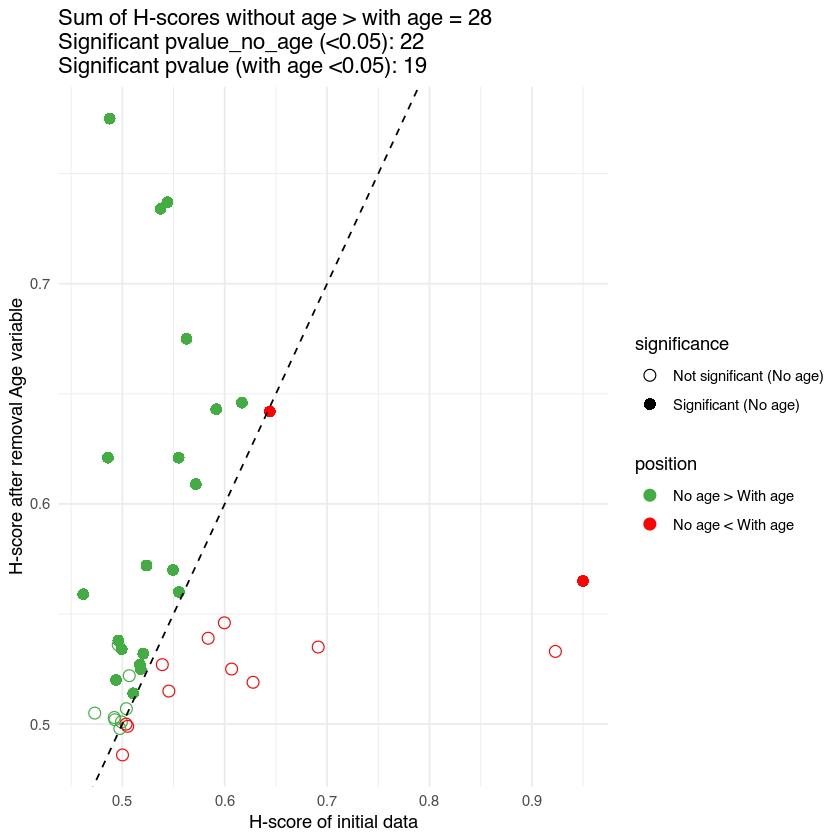

In [7]:
library(dplyr)
library(ggplot2)

# Read the CSV file
result <- read.csv("/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/final_res.csv", sep = ",", header = TRUE)

# Extract columns for plotting
x <- result$H_score
y <- result$H_score_no_Age
pvalue <- result$p_value
pvalue_no_age <- result$p_value_no_Age

# Create a data frame with relevant information
data <- data.frame(x = x, y = y, pvalue = pvalue, pvalue_no_age = pvalue_no_age)

# Add a column for significant p-values
data$significance <- ifelse(data$pvalue_no_age < 0.05, "Significant (No age)", "Not significant (No age)")
data$position <- ifelse(data$y > data$x, "No age > With age", "No age < With age")
data$position <- factor(data$position, levels = c("No age > With age", "No age < With age"))

# Calculate how many points have pvalue_no_age significant
calcul <- sum(data$y > data$x)
significant_count <- sum(data$pvalue_no_age < 0.05)
significant_with_age_count <- sum(data$pvalue < 0.05)
# Plot
scatter_plot <- ggplot(data, aes(x = x, y = y)) +
  geom_point(aes(color = position, shape = significance), size = 3) +  
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black") +  # Line where x = y
  labs(title = paste("Sum of H-scores without age > with age =", calcul,
                     "\nSignificant pvalue_no_age (<0.05):", significant_count,
                     "\nSignificant pvalue (with age <0.05):", significant_with_age_count),
       x = "H-score of initial data",
       y = "H-score after removal Age variable") +
  scale_color_manual(values = c("No age > With age" = "#43ad43", "No age < With age" = "#ff0000fc")) +  # Color points
  scale_shape_manual(values = c("Significant (No age)" = 16, "Not significant (No age)" = 1)) +  # Shape based on significance
  theme_minimal() + theme()

print(scatter_plot)

In [6]:
###подсчет для датасетов, тут считается рандомная аннотация

library(dplyr)
library(ggplot2)
library(ggfortify)
library(gridExtra)
library(grid)

# Define paths to the folders
substracted_age <- "/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/no_age"
datasets <- "/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/new_clock_dataset"

distribution_path <- "/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/distrib_initial"
distribution_path_no_age <- "/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/distrib_no_age"


file_list1 <- list.files(path = datasets, full.names = TRUE)
file_list2 <- list.files(path = substracted_age, full.names = TRUE)

if (length(file_list1) != length(file_list2)) {
  stop("The number of files in each directory does not match.")
}

new_result_table <- data.frame(
  Dataset_ID = character(), 
  H_score = numeric(), 
  p_value = numeric(), 
  H_score_no_Age = numeric(), 
  p_value_no_Age = numeric(), 
  stringsAsFactors = FALSE
)
all_plots <- list()

for (i in 1:length(file_list1)) {
  file1 <- file_list1[i]
  file2 <- file_list2[i]

  # Read the data
  data1 <- read.csv(file1, sep = ",", header = TRUE, row.names = 1)
  data2 <- read.csv(file2, sep = ",", header = TRUE, row.names = 1)


  annotation1 <- data1$Condition
  distMatrix1 <- kendall_dist(data1) # Calculate kendall distances
  distrib_result1 <- distrib_and_hobot(distMatrix1, annotation1, 1000) 
  h_score1 <- distrib_result1$h_val
  p_value1 <- distrib_result1$pval
  sample_id1 <- basename(file1)

  distribution1 <- distrib_result1$random_h_scores # Save the distribution in txt file
  file_path_for_distrib <- file.path(distribution_path, paste0(sample_id1, ".txt"))
  write.table(distribution1, file = file_path_for_distrib, row.names = FALSE, col.names = FALSE)

  # Calculate H-score and p-value for the without age dataset
  annotation2 <- data2$Condition
  distMatrix2 <- kendall_dist(data2) # Calculate kendall distances
  distrib_result2 <- distrib_and_hobot(distMatrix2, annotation2, 1000) 
  h_score2 <- distrib_result2$h_val
  p_value2 <- distrib_result2$pval
  sample_id2 <- basename(file2)

  distribution2 <- distrib_result2$random_h_scores
  file_path_for_distrib_no_age <- file.path(distribution_path_no_age, paste0(sample_id2, ".txt"))
  write.table(distribution2, file = file_path_for_distrib_no_age, row.names = FALSE, col.names = FALSE)

  # Add a new row to the result table
  new_result_table <- new_result_table %>%
    add_row(Dataset_ID = sample_id1, H_score = h_score1, p_value = p_value1, H_score_no_Age = h_score2, p_value_no_Age = p_value2)

  # Plot the distributions
  plot1 <- plot_distrib(distrib_result1)
  plot2 <- plot_distrib(distrib_result2)

  # Perform PCA and plot for the first dataset
  p1 <- PCA_my_plot(data1, sample_id1, "initial data")

  # Perform PCA and plot for the second dataset
  p2 <- PCA_my_plot(data2, sample_id2, "after removing Age variable")

  # Combine plots into a single grid
  combined_plot <- arrangeGrob(plot1, p1, plot2, p2, ncol = 2, nrow = 2)

  # Store the combined plot in the list
  all_plots[[i]] <- combined_plot
}

# Combine all plots into a single file with 2x2 grid per page
pdf("/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/new_set_of_sites.pdf", width = 16, height = 16) 
for (i in seq(1, length(all_plots), by = 1)) {
  grid.newpage()
  grid.draw(all_plots[[i]])
}
dev.off()

# Save the result tables to CSV files
write.csv(new_result_table, "/tank/projects/vpalagina_hobotnica/hobotnica/clocks/a_new_set_for_checks/new_clock_h_scores.csv", row.names = FALSE)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


png 
  2

In [1]:
library(dplyr)
library(ggplot2)

folder_path <- "/tank/projects/vpalagina_hobotnica/hobotnica/clocks_results"
output_pdf <- "/tank/projects/vpalagina_hobotnica/hobotnica/clocks_results/summary_plots_13_models.pdf"

csv_files <- list.files(folder_path, full.names = TRUE)

pdf(output_pdf)

for (csv_file in csv_files) {
  file_name <- basename(csv_file)
  model_name <- sub("_.*", "", file_name)

  result <- read.csv(csv_file, sep = ",", header = TRUE)

  x <- result$H_score
  y <- result$H_score_no_Age
  pvalue <- result$p_value
  pvalue_no_age <- result$p_value_no_Age

  data <- data.frame(x = x, y = y, pvalue = pvalue, pvalue_no_age = pvalue_no_age)

  data$significance <- ifelse(data$pvalue_no_age < 0.05, "Significant (No age)", "Not significant (No age)")
  data$position <- ifelse(data$y > data$x, "No age > With age", "No age < With age")
  data$position <- factor(data$position, levels = c("No age > With age", "No age < With age"))

  calcul <- sum(data$y > data$x)
  significant_count <- sum(data$pvalue_no_age < 0.05)
  significant_with_age_count <- sum(data$pvalue < 0.05)

  scatter_plot <- ggplot(data, aes(x = x, y = y)) +
    geom_point(aes(color = position, shape = significance), size = 3) +  
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black") +  # Line where x = y
    labs(title = paste(model_name, "\nSum of H-scores without age > with age =", calcul,
                       "\nSignificant pvalue_no_age (<0.05):", significant_count,
                       "\nSignificant pvalue (with age <0.05):", significant_with_age_count),
         x = "H-score of initial data",
         y = "H-score after removal Age variable") +
    scale_color_manual(values = c("No age > With age" = "#43ad43", "No age < With age" = "#ff0000fc")) +  # Color points
    scale_shape_manual(values = c("Significant (No age)" = 16, "Not significant (No age)" = 1)) +  # Shape based on significance
    theme_minimal()

  print(scatter_plot)
}

dev.off()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




png 
  2

In [61]:
library(ggplot2)
library(pheatmap)
library(reshape2)
library(dplyr)

combined_df <- read.csv("/tank/projects/vpalagina_hobotnica/hobotnica/clocks/combined_df.csv", row.names = 1)
h_scores_df <- combined_df %>% select(contains("H_score_no_Age"))
colnames(h_scores_df) <- gsub("_H_score_no_Age", "", colnames(h_scores_df))

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(h_scores_df). In the next version, this warning will become an error.”
No id variables; using all as measure variables



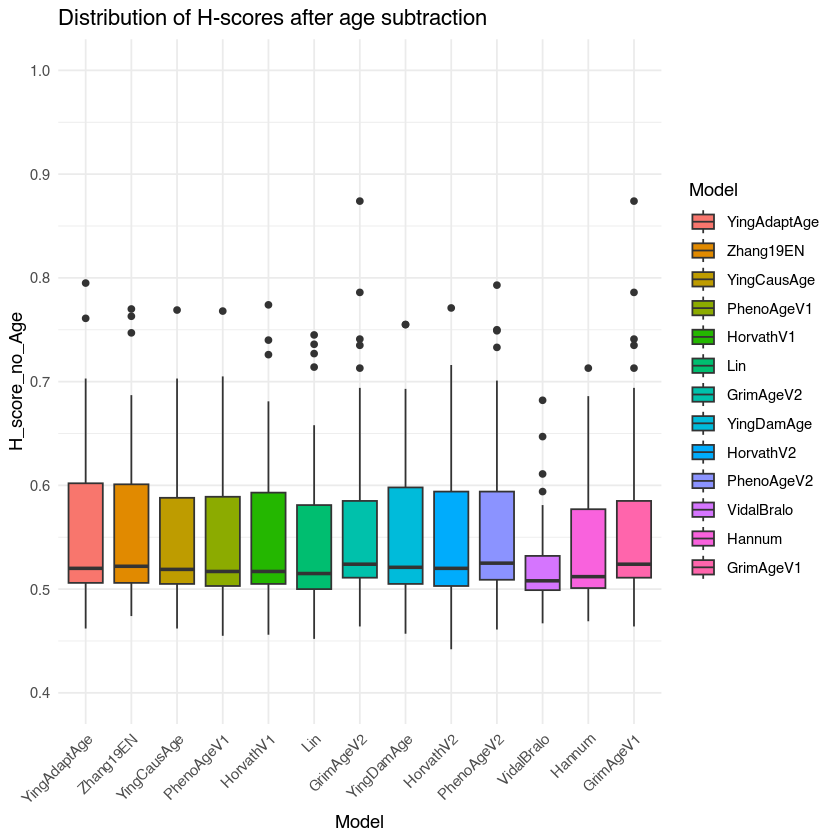

In [62]:
h_scores_melted <- melt(h_scores_df, variable.name = "Model", value.name = "H_score_no_Age")

ggplot(h_scores_melted, aes(x = Model, y = H_score_no_Age, fill = Model)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Distribution of H-scores after age subtraction",
       x = "Model",
       y = "H_score_no_Age") +
  scale_x_discrete() + 
  scale_y_continuous(limits = c(0.4, 1), breaks = seq(0.4, 1, 0.1)) +  # Y-axis from 0.4 to 1
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

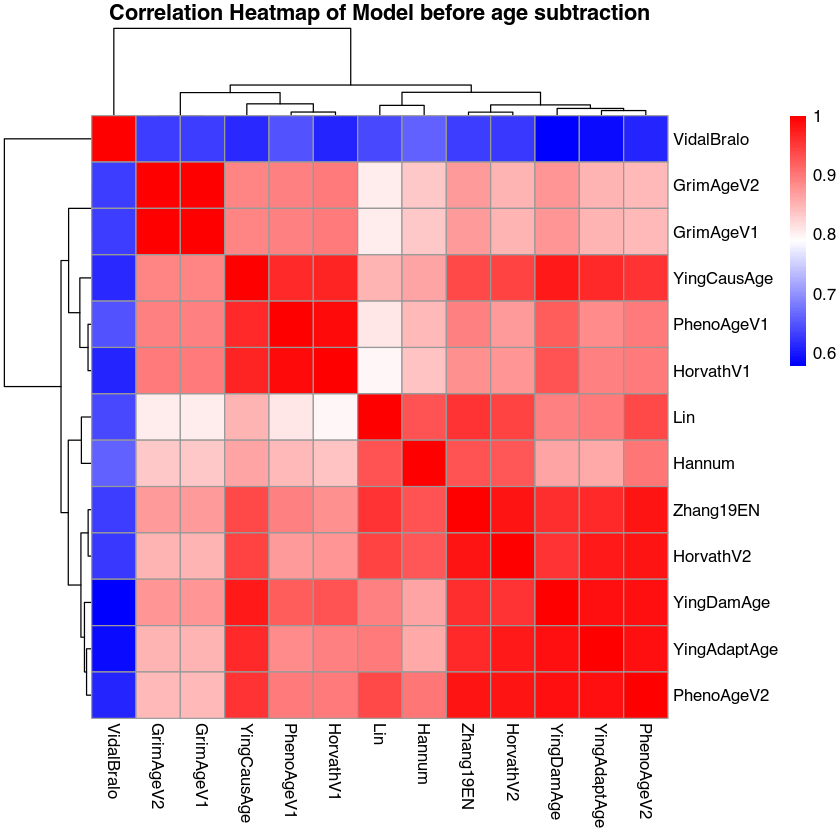

In [17]:
# Calculate correlation matrix between models based on H-scores
cor_matrix <- cor(h_scores_df, use = "pairwise.complete.obs")

pheatmap(cor_matrix,
         main = "Correlation Heatmap of Model before age subtraction",
         color = colorRampPalette(c("blue", "white", "red"))(100),
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         fontsize_row = 10,
         fontsize_col = 10)

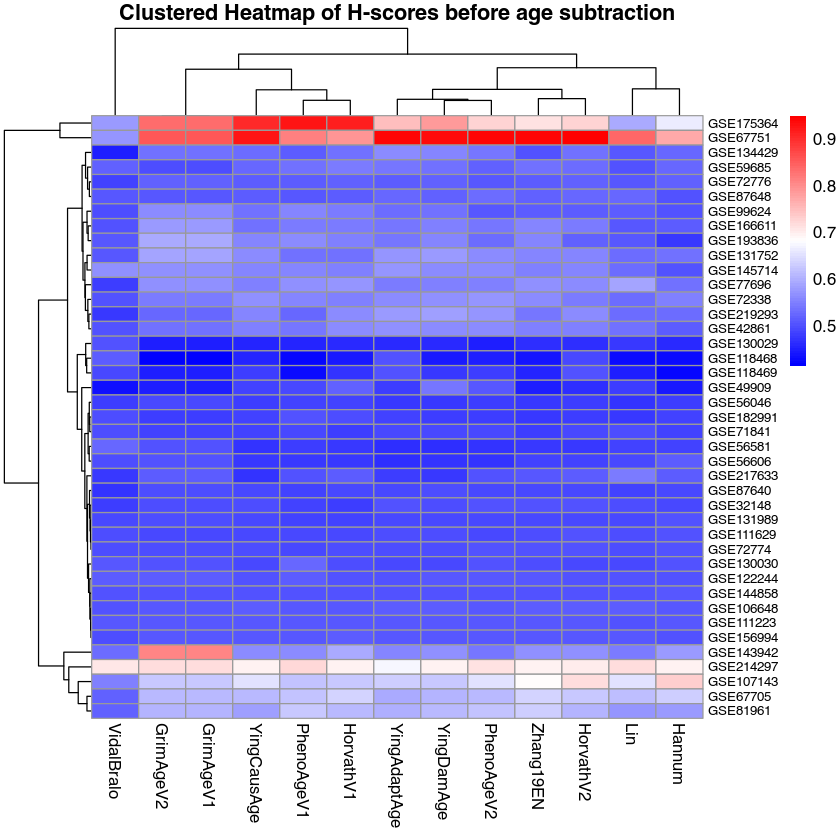

In [18]:
# Clustered heatmap with pheatmap 
pheatmap(as.matrix(h_scores_df), 
         main = "Clustered Heatmap of H-scores before age subtraction",
         color = colorRampPalette(c("blue", "white", "red"))(100),
         clustering_distance_rows = "euclidean",
         clustering_distance_cols = "euclidean",
         clustering_method = "complete",
         fontsize_row = 8,
         fontsize_col = 10)

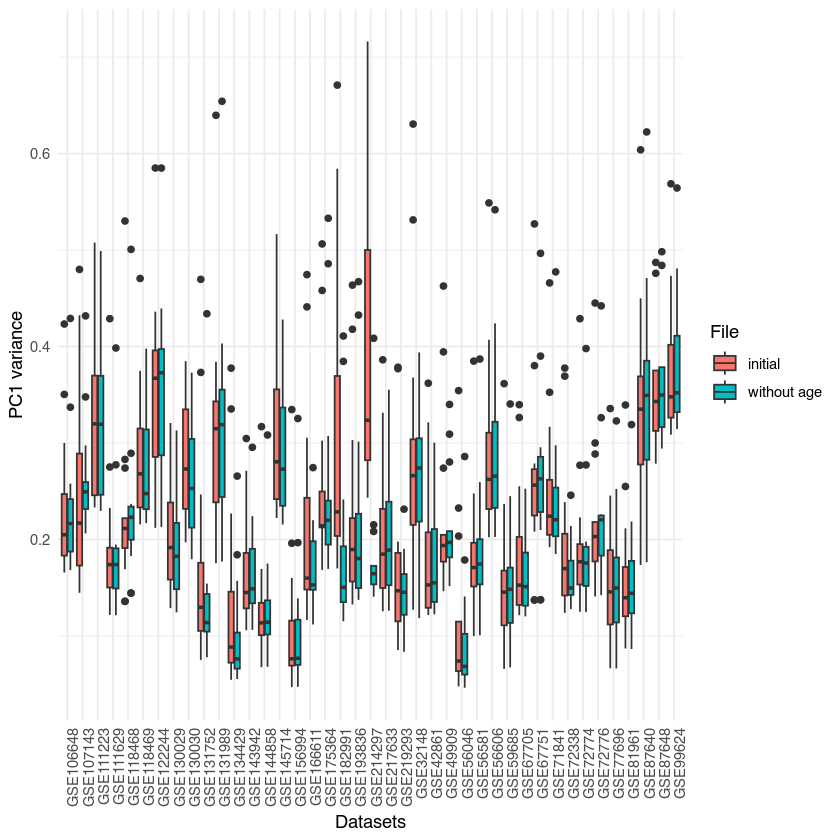

In [33]:
library(ggplot2)
library(reshape2)

df1 <- read.csv("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/pca_variance_initial.csv")
df2 <- read.csv("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/pca_variance_no_age.csv")

colnames(df1)[1] <- "Model"
colnames(df2)[1] <- "Model"

df1_melt <- melt(df1, id.vars = "Model", variable.name = "Dataset_ID", value.name = "PC1_var")
df2_melt <- melt(df2, id.vars = "Model", variable.name = "Dataset_ID", value.name = "PC1_var")

df1_melt$File <- "initial"
df2_melt$File <- "without age"

combined_df <- rbind(df1_melt, df2_melt)

# Adjust the y-axis range to automatically adapt to the data
ggplot(combined_df, aes(x = Dataset_ID, y = PC1_var, fill = File)) +
  geom_boxplot(position = position_dodge(0.8), width = 0.7) +
  labs(x = "Datasets", y = "PC1 variance") +
  scale_y_continuous(limits = range(combined_df$PC1_var, na.rm = TRUE)) + # Auto-adjust y-axis
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

# Save the plot
ggsave("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/pca_ds.png", width = 14, height = 8, dpi = 300)

In [34]:
# Plot the boxplots with larger dimensions and rotated labels
p <- ggplot(combined_df, aes(x = Dataset_ID, y = PC1_var, fill = File)) +
  geom_boxplot(position = position_dodge(0.8), width = 0.7) +
  labs(x = "Datasets", y = "PC1 Variance") +
  scale_y_continuous(limits = range(combined_df$PC1_var, na.rm = TRUE)) + # Auto-scale y-axis
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1), # Rotate dataset labels
    text = element_text(size = 12)  # Increase text size for readability
  ) +
  facet_wrap(~File, scales = "free_x")  # Split plots into separate facets for better visibility

# Save the plot with specified dimensions
ggsave("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/pca_two_sides.png", plot = p, width = 16, height = 10, dpi = 300)

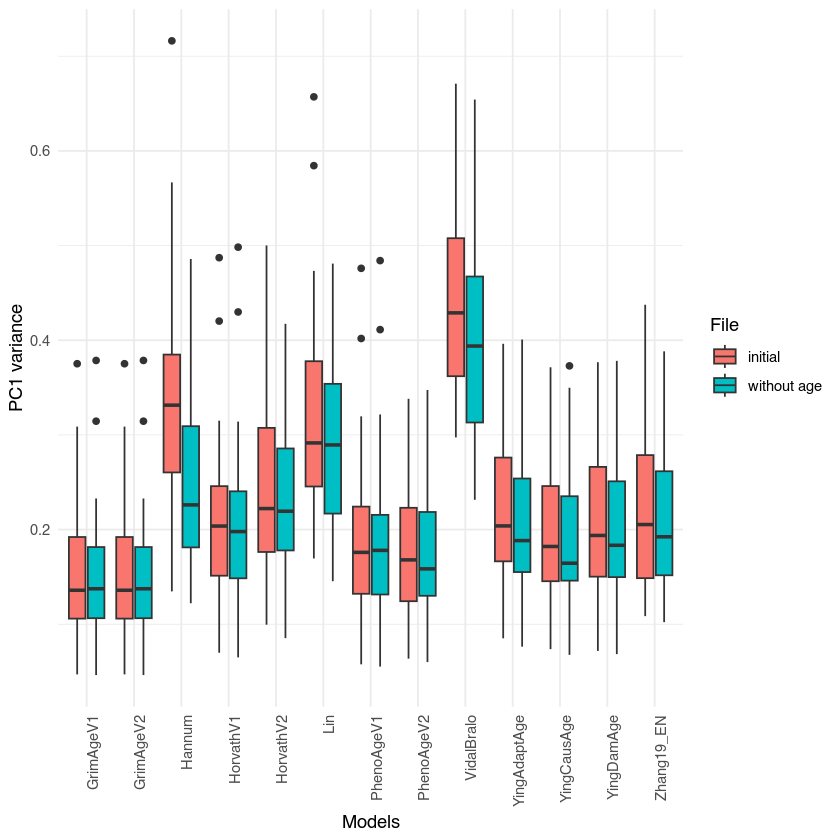

In [38]:
# Load required libraries
library(ggplot2)
library(reshape2)
library(dplyr)

df1 <- read.csv("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/pca_variance_initial.csv")
df2 <- read.csv("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/pca_variance_no_age.csv")

colnames(df1)[1] <- "Model"
colnames(df2)[1] <- "Model"

df1_melt <- melt(df1, id.vars = "Model", variable.name = "Dataset_ID", value.name = "PC1_var")
df2_melt <- melt(df2, id.vars = "Model", variable.name = "Dataset_ID", value.name = "PC1_var")

df1_melt$File <- "initial"
df2_melt$File <- "without age"

combined_df <- rbind(df1_melt, df2_melt)

ggplot(combined_df, aes(x = Model, y = PC1_var, fill = File)) +
  geom_boxplot(position = position_dodge(0.8), width = 0.7) +
  labs(x = "Models", y = "PC1 variance") +
  scale_y_continuous(limits = range(combined_df$PC1_var, na.rm = TRUE)) + # Auto-scale y-axis
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggsave("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/PCA_models_perfomance.png", width = 14, height = 8, dpi = 300)

In [27]:
library(dplyr)

calculate_pca_variation <- function(data) {
  pca_data <- data %>% select(-Condition, -Age)

  if ("Gender" %in% colnames(pca_data)) {
    pca_data <- pca_data %>% select(-Gender)
  }
  pca_data <- pca_data %>% mutate_all(as.numeric)
  pca_result <- prcomp(pca_data, center = TRUE, scale. = TRUE)
  explained_variance_pc1 <- summary(pca_result)$importance[2, 1]
  
  return(explained_variance_pc1)
}

main_folder <- "/tank/projects/vpalagina_hobotnica/hobotnica/clocks"
pca_pc1_results <- list()

model_folders <- list.dirs(main_folder, recursive = FALSE)
for (model_folder in model_folders) {
  no_age_folder <- file.path(model_folder, "no_age")
  dataset_files <- list.files(no_age_folder, full.names = TRUE)
  model_results <- list()
  
  for (dataset_file in dataset_files) {
    data <- read.csv(dataset_file, row.names = 1)
    pc1_variance <- calculate_pca_variation(data)
    dataset_name <- tools::file_path_sans_ext(basename(dataset_file))
    model_results[[dataset_name]] <- pc1_variance
 }
  model_name <- basename(model_folder)
  pca_pc1_results[[model_name]] <- model_results
}
pca_pc1_df <- do.call(rbind, lapply(pca_pc1_results, function(x) {
  data.frame(t(unlist(x)))
}))

rownames(pca_pc1_df) <- names(pca_pc1_results)
colnames(pca_pc1_df) <- unique(unlist(lapply(pca_pc1_results, names)))

write.csv(pca_pc1_df, "/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/pca_variance_no_age.csv", row.names = TRUE)

In [28]:
library(dplyr)

calculate_pca_variation <- function(data) {
  pca_data <- data %>% select(-Condition, -Age)
  if ("Gender" %in% colnames(pca_data)) {
    pca_data <- pca_data %>% select(-Gender)
  }
  pca_data <- pca_data %>% mutate_all(as.numeric)

  pca_result <- prcomp(pca_data, center = TRUE, scale. = TRUE)
  explained_variance_pc1 <- summary(pca_result)$importance[2, 1]
  
  return(explained_variance_pc1)
}

main_folder <- "/tank/projects/vpalagina_hobotnica/hobotnica/clocks"
pca_pc1_results <- list()

model_folders <- list.dirs(main_folder, recursive = FALSE)
for (model_folder in model_folders) {

  datasets_folder <- list.dirs(model_folder, recursive = FALSE, full.names = TRUE)
  datasets_folder <- datasets_folder[grep("datasets_", datasets_folder)]

  if (length(datasets_folder) == 1) {
    dataset_files <- list.files(datasets_folder, full.names = TRUE)

    model_results <- list()
    
    for (dataset_file in dataset_files) {
      data <- read.csv(dataset_file, row.names = 1)
      pc1_variance <- calculate_pca_variation(data)
      dataset_name <- tools::file_path_sans_ext(basename(dataset_file))
      model_results[[dataset_name]] <- pc1_variance
    }

    model_name <- basename(model_folder)
    pca_pc1_results[[model_name]] <- model_results
  } else {
    message(paste("No unique datasets_ folder found in model folder:", model_folder))
  }
}
all_datasets <- unique(unlist(lapply(pca_pc1_results, names)))
pca_pc1_df <- do.call(rbind, lapply(pca_pc1_results, function(x) {
  sapply(all_datasets, function(dataset) x[[dataset]])
}))

rownames(pca_pc1_df) <- names(pca_pc1_results)
colnames(pca_pc1_df) <- all_datasets

write.csv(pca_pc1_df, "/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/pca_variance_initial.csv", row.names = TRUE)

In [35]:
library(dplyr)
library(reshape2)

pca_df <- read.csv("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/pca_variance_no_age.csv")
h_score_df <- read.csv("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/result_for_boxplots.csv")

colnames(pca_df)[1] <- "Model"
colnames(h_score_df)[1] <- "Model"

pca_melt <- melt(pca_df, id.vars = "Model", variable.name = "Dataset_ID", value.name = "PC1_var")
h_score_melt <- melt(h_score_df, id.vars = "Model", variable.name = "Dataset_ID", value.name = "H_score")

combined_data <- merge(pca_melt, h_score_melt, by = c("Model", "Dataset_ID"))

correlation_results <- combined_data %>%
  summarise(correlation = cor(PC1_var, H_score, use = "complete.obs"))

print(correlation_results)

  correlation
1  -0.2030465


In [64]:
# Load necessary libraries
library(dplyr)
library(reshape2)

# Load the data (adjust the path if necessary)
h_scores_df <- read.csv("/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/result_for_boxplots_initial.csv", row.names = 1)

# Convert row names to a column named "Model" to make them accessible in the data frame
h_scores_df <- h_scores_df %>% mutate(Model = rownames(h_scores_df))

# Define thresholds for low and good H-scores
low_threshold <- 0.5
good_threshold <- 0.7

# Melt the data for easier analysis
h_scores_melt <- melt(h_scores_df, id.vars = "Model", variable.name = "Dataset", value.name = "H_score")

# Identify datasets with low H-scores across many models
low_h_scores <- h_scores_melt %>%
  filter(H_score <= low_threshold) %>%
  group_by(Dataset) %>%
  summarise(low_score_count = n()) %>%
  arrange(desc(low_score_count))

# Identify datasets with good H-scores (above threshold) for each model
high_h_scores <- h_scores_melt %>%
  filter(H_score >= good_threshold) %>%
  group_by(Dataset) %>%
  summarise(high_score_count = n()) %>%
  arrange(desc(high_score_count))

write.csv(low_h_scores, "/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/H-scores_ds_perfomances/low_h_score(<0.5)_initial.csv", row.names = TRUE)
write.csv(high_h_scores, "/tank/projects/vpalagina_hobotnica/hobotnica/clocks_result/H-scores_ds_perfomances/high_h_score(>0.7)_initial.csv", row.names = TRUE)

